In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, matplotlib.pyplot as plt, operator as op
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
#import weka.core.converters as converters

## 2. Tree-Based Methods

### a. Dowload APS data

In [2]:
APS_train = pd.read_csv('../data/aps_failure_training_set.csv')
APS_test = pd.read_csv('../data/aps_failure_test_set.csv')

In [3]:
APS_train

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


### b. Data prep

#### i.  Missing values

In [4]:
APS_train = APS_train.replace('na',np.nan)
train_class = APS_train['class']
df_mean = SimpleImputer(missing_values = np.nan,strategy = 'median')
APS_train_x = df_mean.fit_transform(APS_train.drop('class',axis=1))
APS_train_x = pd.DataFrame(df_mean.fit_transform(APS_train_x),columns = APS_train.columns[1:])
APS_train_y_df = APS_train['class']
APS_train_y_df = APS_train_y_df.replace('neg',-1)
APS_train_y_df = APS_train_y_df.replace('pos',1)
APS_train_imp = pd.concat([APS_train_x,APS_train_y_df],axis=1)
APS_train_y = APS_train_y_df.tolist()

APS_test = APS_test.replace('na',np.nan)
test_class = APS_test['class']
df_mean = SimpleImputer(missing_values = np.nan,strategy = 'median')
APS_test_x = df_mean.fit_transform(APS_test.drop('class',axis=1))
APS_test_x = pd.DataFrame(APS_test_x,columns = APS_test.columns[1:])
APS_test_y_df = APS_test['class']
APS_test_y_df = APS_test_y_df.replace('neg',-1)
APS_test_y_df = APS_test_y_df.replace('pos',1)
APS_test_imp = pd.concat([APS_test_x,APS_test_y_df],axis=1)
APS_test_y = APS_test_y_df.tolist()
test_class_df = pd.DataFrame(test_class)
train_class_df=pd.DataFrame(train_class)
APS_train = pd.concat([APS_train_x,train_class_df],axis=1)
APS_test = pd.concat([APS_test_x,test_class_df],axis=1)

#### ii. Coefficient of variation CV

In [5]:
#define function to calculate cv
#cv = lambda x: np.std(x) / np.mean(x)
#APS_CV = APS_train_x.apply(cv)
#APS_CV = pd.DataFrame(APS_CV, columns = ['CV'])
APS_CV = []
for col in APS_train_x.columns:
    std = np.std(APS_train_x[col])
    mean = np.mean(APS_train_x[col])
    APS_CV.append (std/mean)

APS_CV = pd.DataFrame(APS_CV, index = APS_train_x.columns, columns = ['CV'])
APS_CV

,CV
aa_000,2.450917
ab_000,10.383407
ac_000,2.310221
ad_000,244.320780
ae_000,24.199935
...,...
ee_007,5.012712
ee_008,3.259052
ee_009,5.691565
ef_000,49.366248


#### iii. Correlation matrix

In [6]:
APS_imp_corr = APS_train_imp.corr()
APS_imp_corr

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
aa_000,1.000000,0.014085,-0.063876,-0.001590,0.043095,0.062855,0.018549,0.142645,0.284797,0.493749,...,0.736321,0.715000,0.724399,0.724102,0.603888,0.469836,0.247149,0.012409,0.024387,0.536978
ab_000,0.014085,1.000000,-0.002128,-0.000394,0.037572,0.053293,-0.000179,0.007839,0.023144,0.037081,...,0.013330,0.002849,0.004470,0.015881,0.008520,-0.025599,-0.016247,0.056271,0.106360,0.015084
ac_000,-0.063876,-0.002128,1.000000,-0.001765,-0.004250,-0.009480,0.017155,-0.007334,-0.022708,-0.047927,...,-0.040157,-0.039319,-0.039648,-0.047105,-0.048648,-0.003714,0.013764,-0.006262,0.014747,-0.050996
ad_000,-0.001590,-0.000394,-0.001765,1.000000,-0.000168,-0.000209,-0.000043,-0.000115,-0.000230,-0.000469,...,-0.001529,-0.001494,-0.001239,-0.001201,-0.000801,-0.001235,-0.000716,-0.000082,-0.000096,-0.000530
ae_000,0.043095,0.037572,-0.004250,-0.000168,1.000000,0.823123,-0.000445,-0.001072,0.002204,0.022460,...,0.016818,0.011363,0.026130,0.060474,0.035503,-0.009632,-0.007218,0.070869,0.041725,0.005541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_008,0.469836,-0.025599,-0.003714,-0.001235,-0.009632,-0.012347,-0.000787,0.004927,0.009562,0.021448,...,0.481672,0.459834,0.407250,0.374332,0.225378,1.000000,0.710167,-0.005963,-0.002842,0.235401
ee_009,0.247149,-0.016247,0.013764,-0.000716,-0.007218,-0.008996,-0.001209,-0.004274,-0.009410,-0.019093,...,0.239576,0.224931,0.190958,0.164162,0.061805,0.710167,1.000000,-0.003439,-0.000971,0.115925
ef_000,0.012409,0.056271,-0.006262,-0.000082,0.070869,0.106312,-0.000078,0.001793,0.006870,0.012996,...,0.011816,0.003236,0.032363,0.004613,-0.001733,-0.005963,-0.003439,1.000000,0.282201,0.013650
eg_000,0.024387,0.106360,0.014747,-0.000096,0.041725,0.060756,0.000236,0.007453,0.020783,0.015315,...,0.008727,0.009714,0.010990,0.021720,0.000398,-0.002842,-0.000971,0.282201,1.000000,0.012809


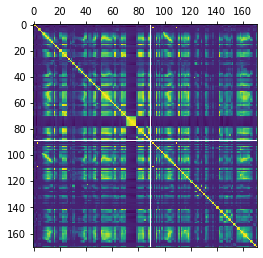

In [7]:
plt.matshow(APS_imp_corr)

#### iv. Sort, pick (170)^(1/2) ,scatterplots, boxplots

In [8]:
num = int((170)**(1/2))
num

13

In [9]:
APS_CV_highest13 = APS_CV.sort_values(by = ['CV'], ascending=False)[:13]
#CC_CV_highest11 = CC_CV_highest.iloc[:11]
APS_CV_highest13

,CV
cf_000,244.885476
co_000,244.505347
ad_000,244.320780
cs_009,237.928571
dh_000,123.215070
dj_000,117.493246
ag_000,92.916981
as_000,87.331772
ay_009,84.733028
ak_000,80.424305


In [10]:
highest13_CV_name = APS_CV_highest13.index.tolist()
APS_highest13 = APS_train_imp[highest13_CV_name]
APS_highest13

,cf_000,co_000,ad_000,cs_009,dh_000,dj_000,ag_000,as_000,ay_009,ak_000,az_009,ch_000,au_000
0,2.0,220.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,8.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,2.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,202.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,224.0,186.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,2.0,0.0,224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,2.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,2.0,580.0,494.0,0.0,190.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:

APS_highest13_forplot = pd.concat([APS_highest13,APS_train_y_df],axis=1)
APS_highest13_forplot

,cf_000,co_000,ad_000,cs_009,dh_000,dj_000,ag_000,as_000,ay_009,ak_000,az_009,ch_000,au_000,class
0,2.0,220.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,2.0,8.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,2.0,2.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
4,0.0,202.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,224.0,186.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
59996,2.0,0.0,224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
59997,2.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
59998,2.0,580.0,494.0,0.0,190.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


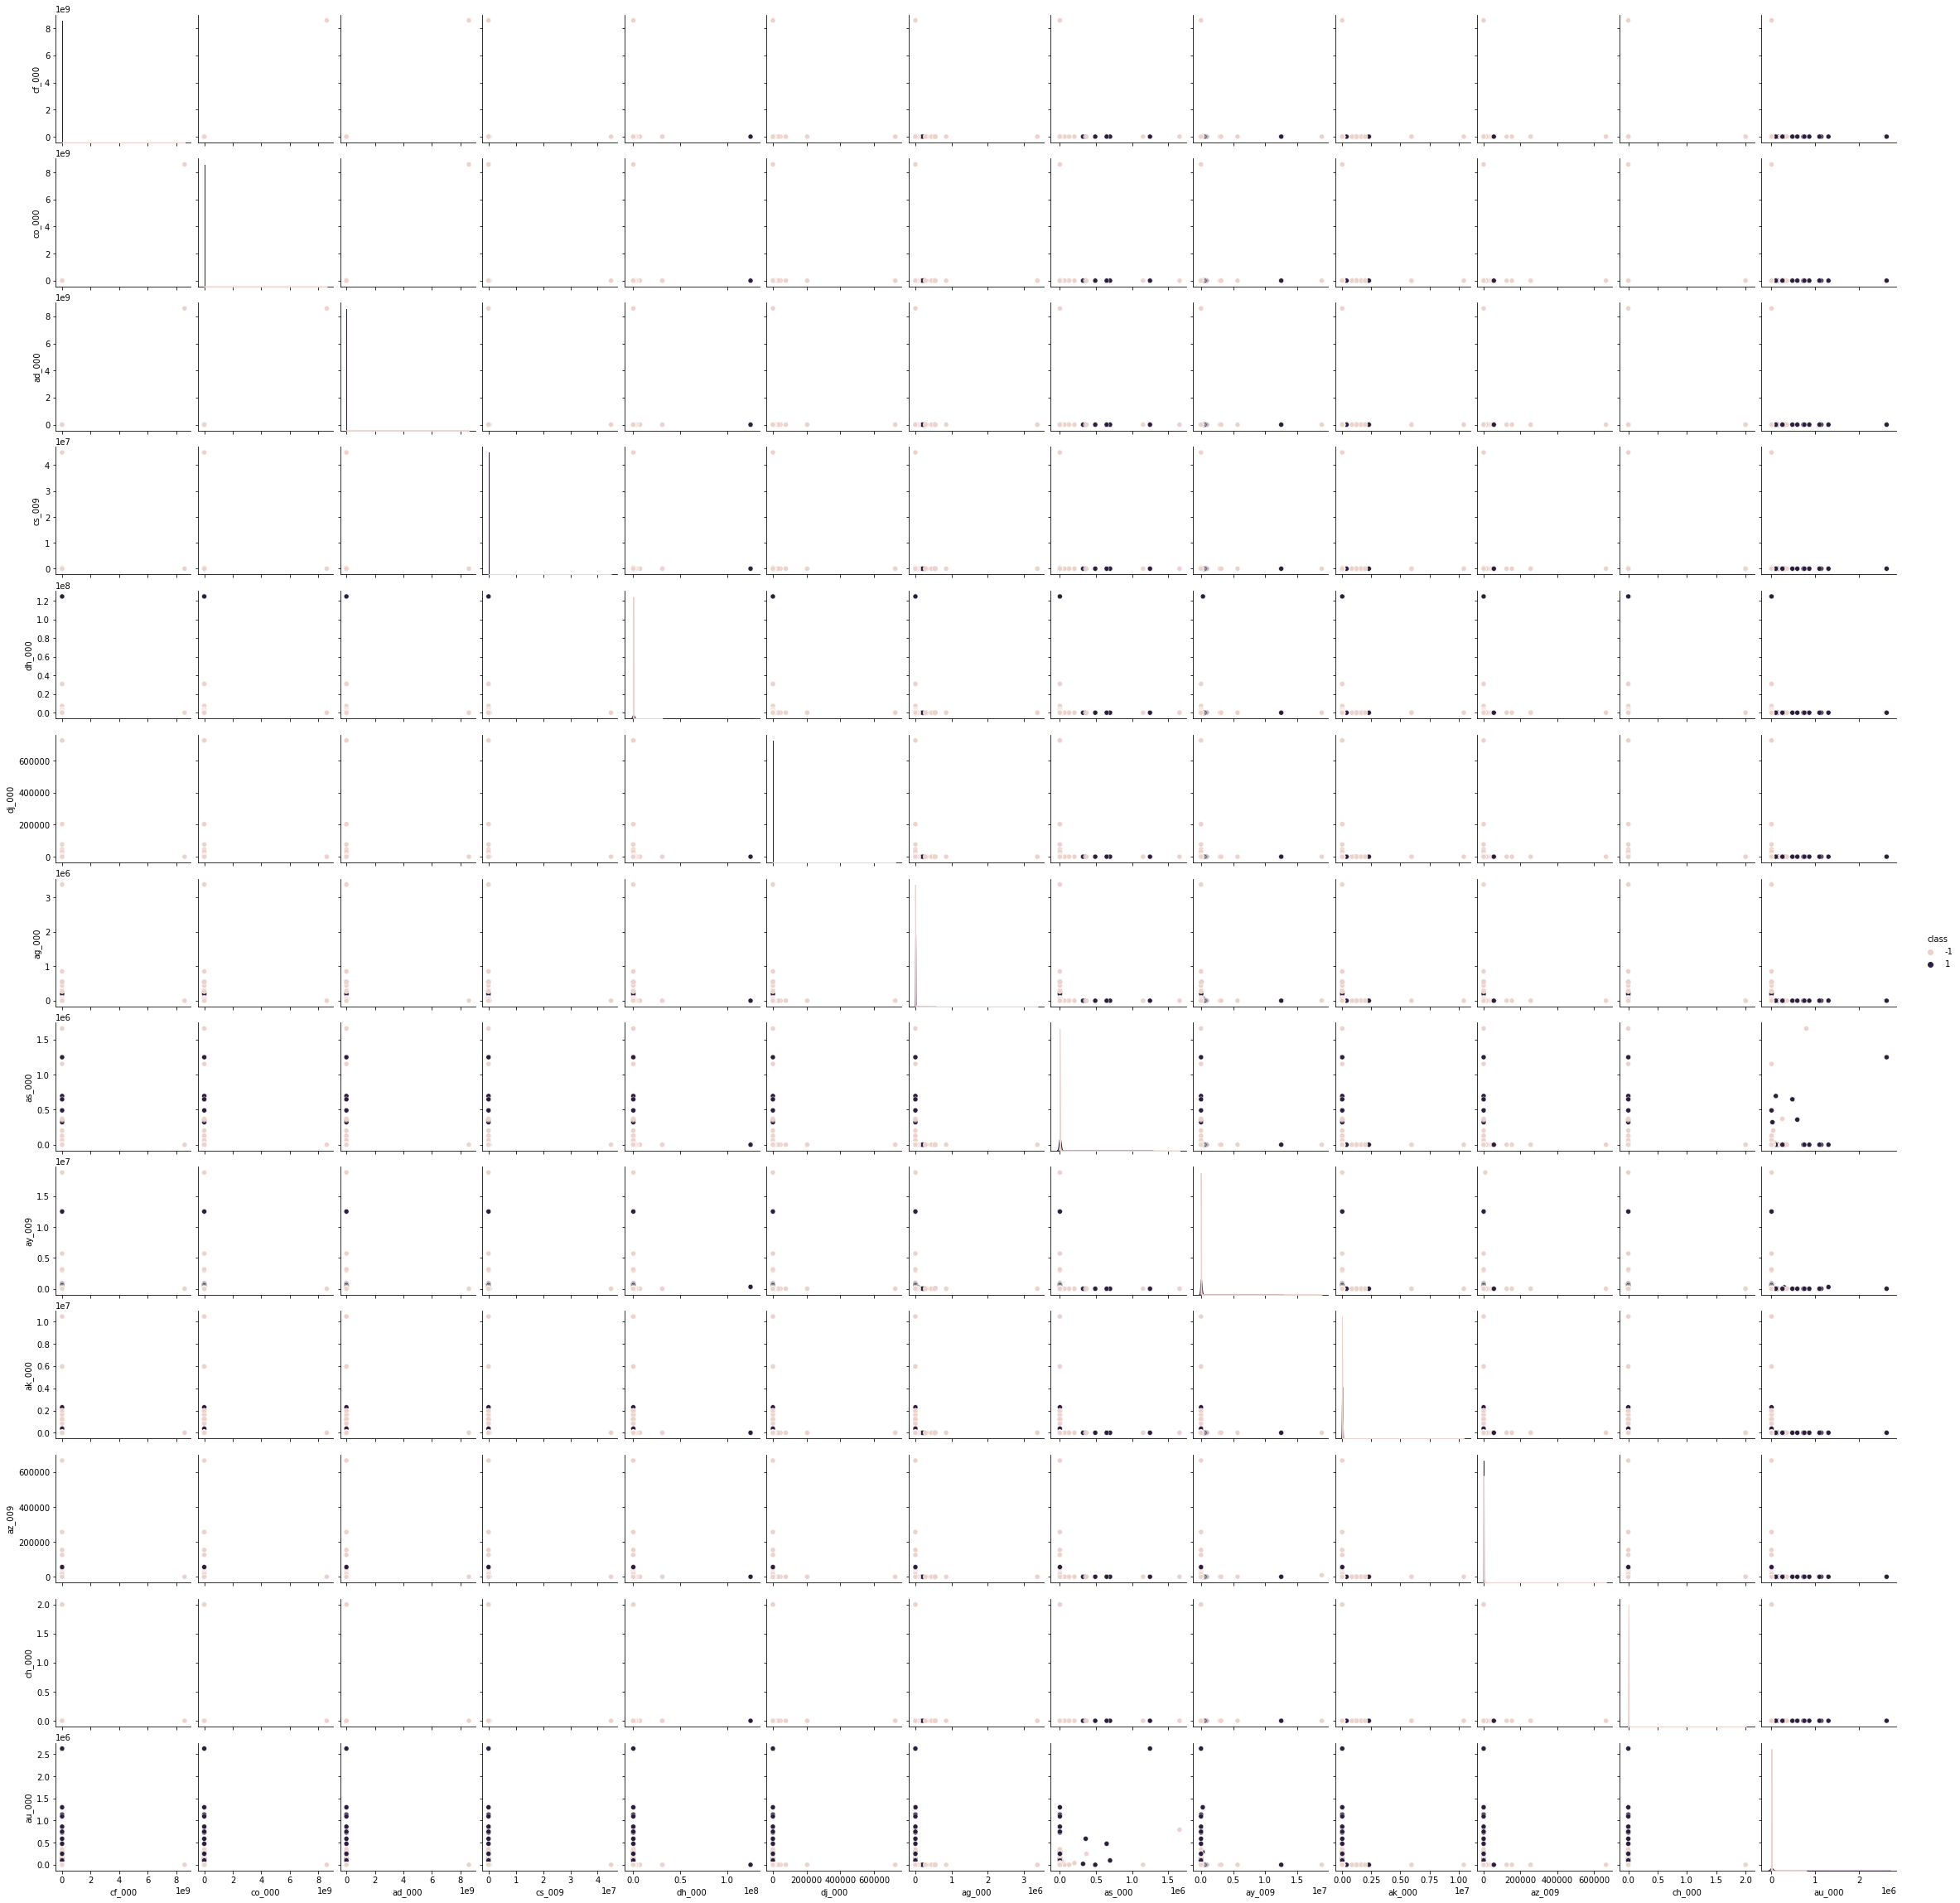

In [12]:
sns.pairplot(APS_highest13_forplot, hue = 'class')

Conclusion: no correlation relationship could be drawn from the pairplot without drop the outliers.

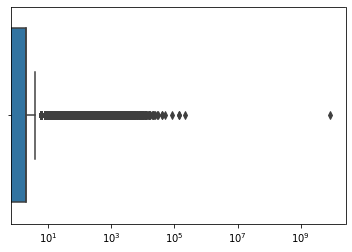

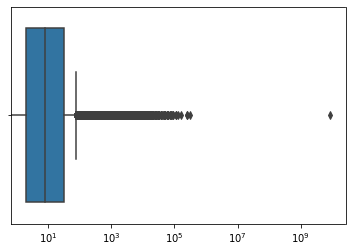

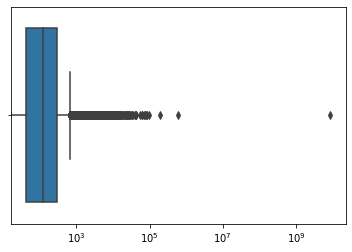

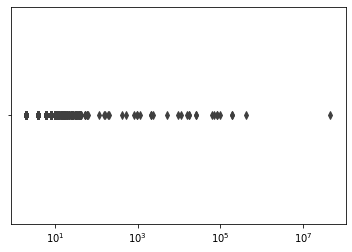

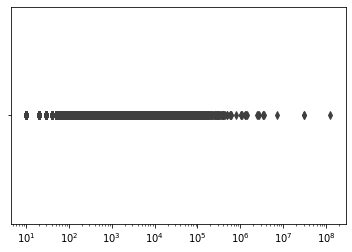

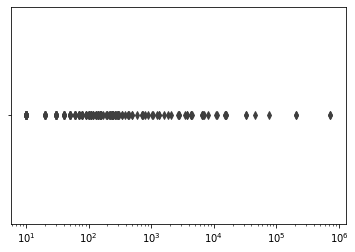

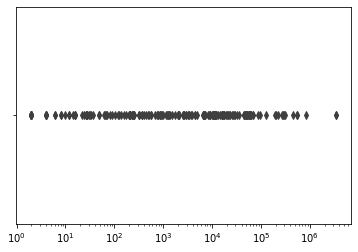

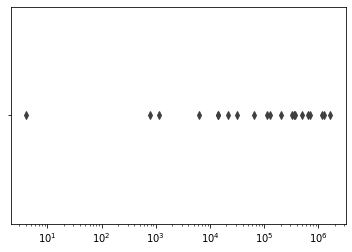

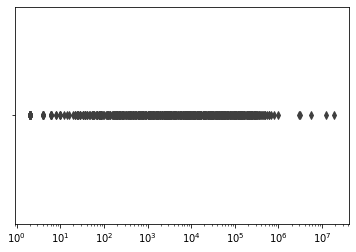

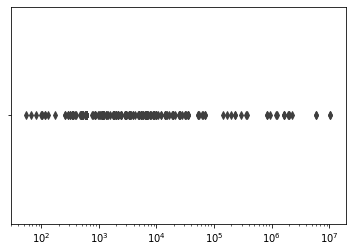

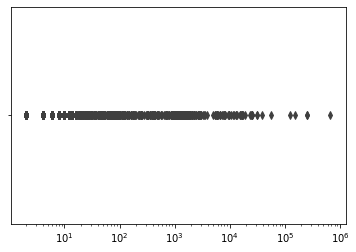

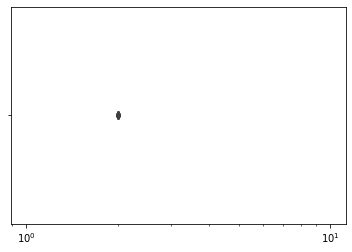

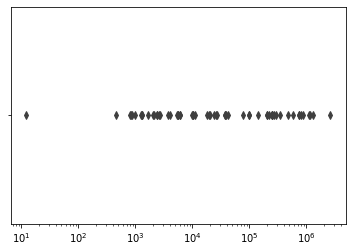

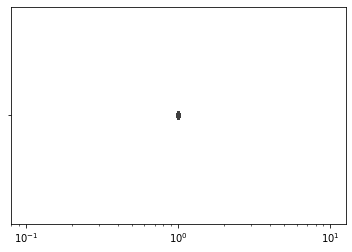

In [13]:
# Boxplot
box_plot_dict = {}
for col in APS_highest13_forplot.columns:
    box_plot_dict[col] = APS_highest13_forplot[col].tolist()
for key, val in box_plot_dict.items():
    box = sns.boxplot(x=val).set(xscale='log')
    #set_title(key)
    #box.
    plt.show()


####  # of pos & neg data

In [14]:
APS_train_y_df.value_counts()

-1    59000
 1     1000
Name: class, dtype: int64

Yes it is a very imbalanced data.

### c. Random forest

In [15]:
rfc = RandomForestClassifier(random_state=15,oob_score = True)
rfc.fit(APS_train_x, APS_train_y)
train_pred = rfc.predict(APS_train_x)
test_pred = rfc.predict(APS_test_x)




In [16]:
train_error = 1- rfc.score(APS_train_x, APS_train_y)
train_error

0.0

In [17]:
train_confusion_matrix = confusion_matrix (APS_train_y,train_pred)
train_confusion_matrix

array([[59000,     0],
       [    0,  1000]])

0.0000000.0000002.000000
0.0000001.0000001.000000
1.0000001.000000-1.000000


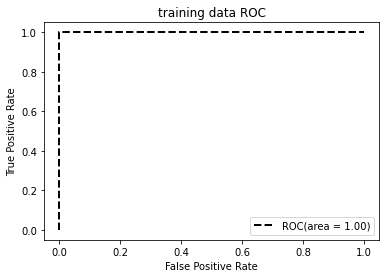

auc for training data is 1.0


In [18]:
train_pred
APS_train_y
fpr, tpr, thresholds = roc_curve(APS_train_y, train_pred)
for i, value in enumerate (thresholds):
    print ('%f%f%f'%(fpr[i],tpr[i],value))

roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,'k--',label = 'ROC(area = {0:.2f})'.format(roc_auc),lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('training data ROC')
plt.legend(loc="lower right")
plt.show()

print ('auc for training data is', roc_auc)

In [19]:
test_error = 1-rfc.score(APS_test_x, APS_test_y)
test_error

0.0075625000000000275

In [20]:
test_confusion_matrix = confusion_matrix(APS_test_y, test_pred)
test_confusion_matrix 

array([[15609,    16],
       [  105,   270]])

In [21]:
fpr, tpr, thresholds = roc_curve(APS_test_y, test_pred)
tpr

array([0.  , 0.72, 1.  ])

0.0000000.0000002.000000
0.0010240.7200001.000000
1.0000001.000000-1.000000


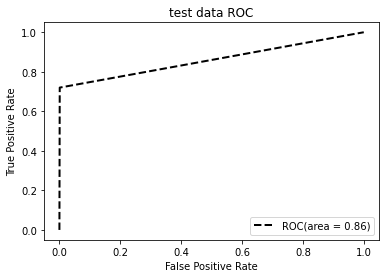

auc for test data is 0.859488


In [22]:
fpr, tpr, thresholds = roc_curve(APS_test_y, test_pred)
for i, value in enumerate (thresholds):
    print ('%f%f%f'%(fpr[i],tpr[i],value))

roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,'k--',label = 'ROC(area = {0:.2f})'.format(roc_auc),lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('test data ROC')
plt.legend(loc="lower right")
plt.show()

print ('auc for test data is', roc_auc)

In [23]:
Out_of_Bag_error = 1-rfc.oob_score_
Out_of_Bag_error

0.006166666666666654

Comparison: the out of bag error is slightly smaller than the test error

### d. Conpensate for class imbalance

In [24]:
rfc = RandomForestClassifier(random_state=15,oob_score = True,class_weight = 'balanced')
rfc.fit(APS_train_x, APS_train_y)
train_pred = rfc.predict(APS_train_x)
test_pred = rfc.predict(APS_test_x)


In [25]:
train_error = 1- rfc.score(APS_train_x, APS_train_y)
train_error

0.0

In [26]:
train_confusion_matrix = confusion_matrix (APS_train_y,train_pred)
train_confusion_matrix

array([[59000,     0],
       [    0,  1000]])

0.0000000.0000002.000000
0.0000001.0000001.000000
1.0000001.000000-1.000000


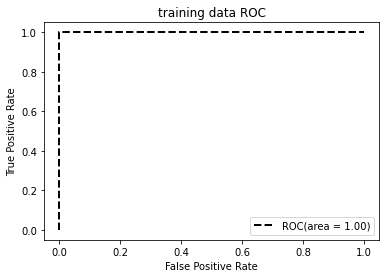

auc for training data is 1.0


In [27]:
train_pred
APS_train_y
fpr, tpr, thresholds = roc_curve(APS_train_y, train_pred)
for i, value in enumerate (thresholds):
    print ('%f%f%f'%(fpr[i],tpr[i],value))

roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,'k--',label = 'ROC(area = {0:.2f})'.format(roc_auc),lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('training data ROC')
plt.legend(loc="lower right")
plt.show()

print ('auc for training data is', roc_auc)

In [28]:
test_error = 1-rfc.score(APS_test_x, APS_test_y)
test_error

0.010624999999999996

In [29]:
test_confusion_matrix = confusion_matrix(APS_test_y, test_pred)
test_confusion_matrix 

array([[15613,    12],
       [  158,   217]])

In [30]:
fpr, tpr, thresholds = roc_curve(APS_test_y, test_pred)
tpr

array([0.        , 0.57866667, 1.        ])

0.0000000.0000002.000000
0.0007680.5786671.000000
1.0000001.000000-1.000000


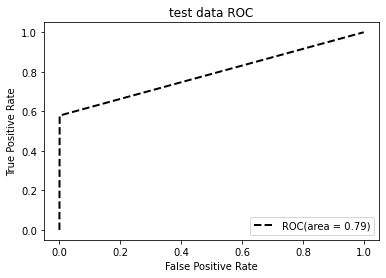

auc for test data is 0.7889493333333333


In [31]:
fpr, tpr, thresholds = roc_curve(APS_test_y, test_pred)
for i, value in enumerate (thresholds):
    print ('%f%f%f'%(fpr[i],tpr[i],value))

roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,'k--',label = 'ROC(area = {0:.2f})'.format(roc_auc),lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('test data ROC')
plt.legend(loc="lower right")
plt.show()

print ('auc for test data is', roc_auc)

In [32]:
Out_of_Bag_error = 1-rfc.oob_score_
Out_of_Bag_error

0.00773333333333337

Comparison: The test error and out of bag error is higher for adjusted random forest classification (as in d), compared with the raw data (as in c).